In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([62]))


In [8]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self._set_extra_params_names(['var'])
        self.start_params = np.array([1]*(self.exog.shape[1]+1))
        self.ols = ols
        #self.start_params = np.array( range(1, (2*self.exog.shape[1]+2)))
        #2 sets of params for z, 1 for x, 2 variances...
    
    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        
       
        #if complete case, assign pr missing to all observations...
        pr_m = stats.norm.logcdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
        
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        if ols: #if OLS use all the data...
            m, m_x = np.ones(y.shape), np.ones(x.shape)
        
        
        b = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        s =  np.sqrt(sigma2)

        beta_jac = np.zeros(len(b))
        sigma_jac = 0
        
        #for censored
        if not cc and not ols: 
            left_stats = (y - np.dot(x, b)) / s
            l_pdf = scipy.stats.norm.logpdf(left_stats)
            l_cdf = scipy.stats.norm.logcdf(left_stats)
            left_frac = np.exp(l_pdf - l_cdf)
            beta_left = np.dot(left_frac*m, x*m_x / s)
            beta_jac -= beta_left
            left_sigma = np.dot(left_frac*m, left_stats*m)
            sigma_jac -= left_sigma
        
        #for non-censored
        mid_stats = (y - np.dot(x, b)) / s
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) / s)
        beta_jac += beta_mid
        mid_sigma = ((np.square(mid_stats) - 1)*(1-m)).sum()
        sigma_jac += mid_sigma
        
        combo_jac = np.append(beta_jac, sigma_jac / (2*s) )  # by chain rule, since the expression above is dloglik/dlogsigma
        return combo_jac



model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
print(model1_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                                Tobit Results                                 
Dep. Variable:                      y   Log-Likelihood:                -1358.3
Model:                          Tobit   AIC:                             2721.
Method:            Maximum Likelihood   BIC:                             2730.
Date:                Tue, 09 Mar 2021                                         
Time:                        14:52:03                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0548      0.046     23.121      0.000       0.965       1.144
x1             0.2490      0.006     39.765      0.0

In [9]:
def compute_llr(yn,xn):
    
    #fit normal values
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),ols=True)
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

print(compute_llr(yn,xn))

(-4.127941212524092, 0.1413668958226576)


0
2


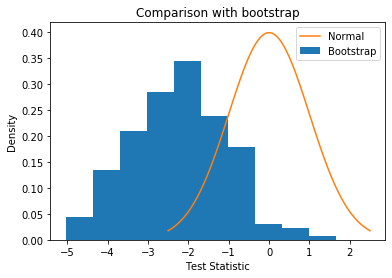

In [10]:
yn,xn,nobs = gen_data()
print(vuong_tests.bootstrap_test(yn,xn,nobs,compute_llr,hist=True))
print(vuong_tests.regular_test(yn,xn,nobs,compute_llr,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('../figs/bootstrap_compare_tobitcc')
plt.show()

In [11]:
def setup_shi(yn,xn):
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    k1 = len(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),ols=True)
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    k2 = len(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

In [ ]:
reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))

shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

In [ ]:
def gen_data(beta0=beta0,beta1=1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))

shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

In [ ]:
def gen_data(beta0=beta0,beta1=1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    m = beta0 + epsilon
    #censor
    y[m<=0] = 0
    
reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))

shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)